#### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Preprocessing

In [2]:
# load data and remove irrelevant feature
data = pd.read_csv('../../CVD_cleaned.csv').drop('Checkup', axis=1)

In [3]:
# convert categorical variables to category
categorical_cols = ['General_Health', 'Age_Category', 'Sex']
for col in categorical_cols:
  data[col] = data[col].astype('category')

# define categories in the correct order for ordinal encoding
health_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
sex_order = ['Female', 'Male']
# encode categories
ordinal_encoder = OrdinalEncoder(categories=[health_order, age_order, sex_order])
# fit and transform categorical columns
data[categorical_cols] = ordinal_encoder.fit_transform(data[categorical_cols])


# convert binary cols (yes/no) to binary (1/0)
binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
               'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
for col in binary_cols:
  # if string contains 'Yes' or 'No' due to pre-diabetes and gestational diabetes:
  data[col] = data[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x))
  data[col] = data[col].astype('category')

In [4]:
# train test split (can do this last since our preprocessing does not touch Heart_Disease other than binary conversion)
X = data.drop('Heart_Disease', axis=1)
y = data['Heart_Disease']

# 80-20 split due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=1, stratify=y)

print('training:', X_train.shape[0], 'individuals')
print('test:', X_test.shape[0], 'individuals\n')
print('case/control distribution in training set:', y_train.value_counts(normalize=True), '\n')
print('case/control distribution in test set:', y_test.value_counts(normalize=True))

training: 247083 individuals
test: 61771 individuals

case/control distribution in training set: Heart_Disease
0    0.919149
1    0.080851
Name: proportion, dtype: float64 

case/control distribution in test set: Heart_Disease
0    0.919153
1    0.080847
Name: proportion, dtype: float64


In [5]:
# save preprocessed data
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

# Model Training

#### Load data

In [6]:
# load data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

#### Define variables

In [ ]:
n_iterations = 100     # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter 

smote_sampling_strategy_values = [1.0, 0.75, 0.5, 0.25]

n_estimator_min = 100
n_estimator_max = 1001
n_estimator_step = 100

max_depth_min = 5
max_depth_max = 31
max_depth_step = 5

sample_leaf_split_values = [2,5,10]

min_samples_leaf_values = [1,2,4]

max_features_values = [None, 'sqrt', 'log2']

bootstrap_values = [True, False]

class_weight_values = [None, 'balanced', 'balanced_subsample']

#### Search grid and RF definition

In [8]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=1)),
    ('rf', RandomForestClassifier(random_state=1, n_jobs=-1))
])

# Hyperparameter grid
param_dist = {
    'smote__sampling_strategy': smote_sampling_strategy_values,
    
    'rf__n_estimators': np.arange(n_estimator_min, n_estimator_max, n_estimator_step),
    'rf__max_depth': [None] + list(np.arange(max_depth_min, max_depth_max, max_depth_step)),
    'rf__min_samples_split': sample_leaf_split_values,
    'rf__min_samples_leaf': min_samples_leaf_values,
    'rf__max_features': max_features_values,
    'rf__bootstrap': bootstrap_values,
    'rf__class_weight': class_weight_values,
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=n_iterations,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=1
)

#### Train model

In [9]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END rf__bootstrap=True, rf__class_weight=None, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=300, smote__sampling_strategy=0.25; total time= 3.4min
[CV] END rf__bootstrap=True, rf__class_weight=None, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=300, smote__sampling_strategy=0.25; total time= 3.4min
[CV] END rf__bootstrap=True, rf__class_weight=None, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=300, smote__sampling_strategy=0.25; total time= 3.5min
[CV] END rf__bootstrap=True, rf__class_weight=None, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=300, smote__sampling_strategy=0.25; total time= 3.5min
[CV] END rf__bootstrap=True, rf__class_weight=None, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_sampl

,estimator,Pipeline(step...om_state=1))])
,param_distributions,"{'rf__bootstrap': [True, False], 'rf__class_weight': [None, 'balanced', ...], 'rf__max_depth': [None, np.int64(5), ...], 'rf__max_features': [None, 'sqrt', ...], ...}"
,n_iter,1
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,1
,error_score,nan


# Model Evaluation

Best hyperparameters: {'smote__sampling_strategy': 0.25, 'rf__n_estimators': np.int64(300), 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__class_weight': None, 'rf__bootstrap': True}
Accuracy: 0.91942821064901
AUROC: 0.8211398264634012
Confusion Matrix:
 [[56623   154]
 [ 4823   171]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56777
           1       0.53      0.03      0.06      4994

    accuracy                           0.92     61771
   macro avg       0.72      0.52      0.51     61771
weighted avg       0.89      0.92      0.89     61771



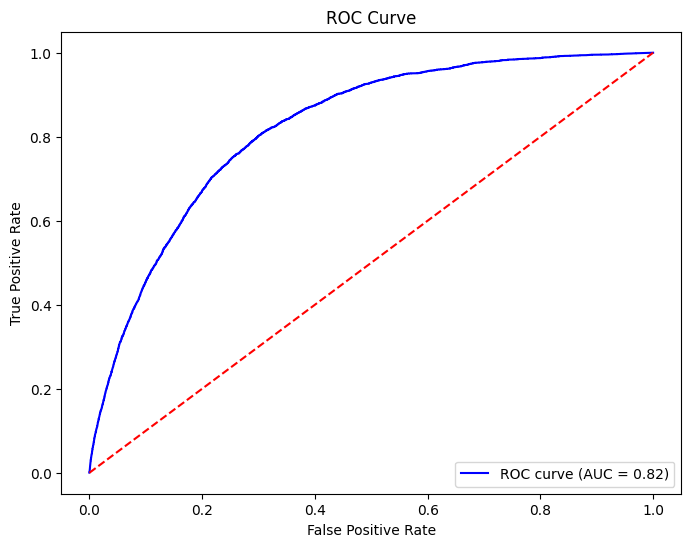

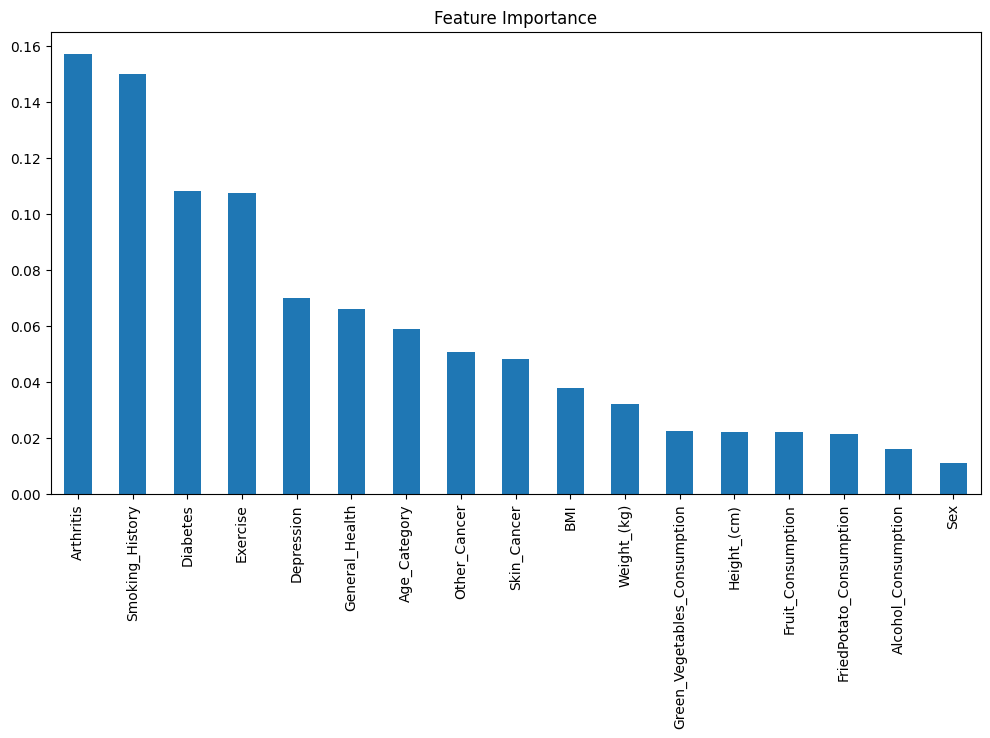

In [10]:
# Best parameters
print("Best hyperparameters:", random_search.best_params_)

# Best estimator
best_rf = random_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print("AUROC:", auroc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
feat_importances = pd.Series(best_rf.named_steps['rf'].feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title('Feature Importance')
plt.show()
